In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Inicia la sesión de Spark
spark = SparkSession.builder.appName("TaylorDataClustering").getOrCreate()

# Carga los datos desde el CSV
data = spark.read.csv("taylor.csv", header=True, inferSchema=True, sep=";")

In [2]:
data.head(2)

[Row(album='Taylor Swift', title='Tim McGraw', year=2006, duration=datetime.datetime(2024, 2, 9, 3, 52), spotify=102, youtube='50', grade='7,9'),
 Row(album='Taylor Swift', title='Picture To Burn', year=2008, duration=datetime.datetime(2024, 2, 9, 2, 53), spotify=143, youtube='118', grade='8,85')]

In [3]:
from pyspark.sql.functions import hour, minute, second, col, to_date, day, month, to_timestamp

data = data.withColumn("duration", to_timestamp(col("duration"), "dd/MM/yyyy HH:mm:ss"))
data = data.withColumn("minutes", hour(col("duration")))
data = data.withColumn("seconds", minute(col("duration")))
data = data.withColumn("duration", col("minutes") * 60 + col("seconds"))

In [4]:
from pyspark.sql.functions import regexp_replace

data = data.withColumn("grade", regexp_replace("grade", ",", "."))
data = data.withColumn("grade", data["grade"].cast("double"))
data = data.withColumn("youtube", data["youtube"].cast("integer"))
data = data.withColumn("spotify", data["spotify"].cast("integer"))

In [5]:
print(data.columns)
print(data.printSchema())

['album', 'title', 'year', 'duration', 'spotify', 'youtube', 'grade', 'minutes', 'seconds']
root
 |-- album: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- spotify: integer (nullable = true)
 |-- youtube: integer (nullable = true)
 |-- grade: double (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- seconds: integer (nullable = true)

None


In [6]:
# Elimina las filas con valores nulos
data = data.dropna()

data.printSchema()

root
 |-- album: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- spotify: integer (nullable = true)
 |-- youtube: integer (nullable = true)
 |-- grade: double (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- seconds: integer (nullable = true)



In [7]:
# Selecciona las columnas relevantes
data = data.select("duration", "grade")

# Convierte los datos a un formato adecuado para KMeans
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
final_data = assembler.transform(data)

In [8]:
# Instancia el modelo KMeans con el número deseado de clusters
k_value = 5
kmeans = KMeans(featuresCol="features", k=k_value)

# Entrena el modelo
model = kmeans.fit(final_data)

In [9]:
# Obtiene las etiquetas de los clusters
predictions = model.transform(final_data)

# Visualiza los resultados
predictions.show()

+--------+-----+-------------+----------+
|duration|grade|     features|prediction|
+--------+-----+-------------+----------+
|     232|  7.9|  [232.0,7.9]|         4|
|     173| 8.85| [173.0,8.85]|         0|
|     203|  8.7|  [203.0,8.7]|         0|
|     242| 8.35| [242.0,8.35]|         4|
|     201| 8.65| [201.0,8.65]|         0|
|     213|  8.6|  [213.0,8.6]|         0|
|     241|9.725|[241.0,9.725]|         4|
|     294|  7.6|  [294.0,7.6]|         3|
|     235| 9.45| [235.0,9.45]|         4|
|     234|  8.2|  [234.0,8.2]|         4|
|     231| 9.74| [231.0,9.74]|         4|
|     261|  7.2|  [261.0,7.2]|         3|
|     243| 9.65| [243.0,9.65]|         4|
|     245|  6.9|  [245.0,6.9]|         4|
|     279| 7.65| [279.0,7.65]|         3|
|     237| 7.35| [237.0,7.35]|         4|
|     263| 7.45| [263.0,7.45]|         3|
|     277|  9.2|  [277.0,9.2]|         3|
|     237| 8.75| [237.0,8.75]|         4|
|     231|  9.2|  [231.0,9.2]|         4|
+--------+-----+-------------+----

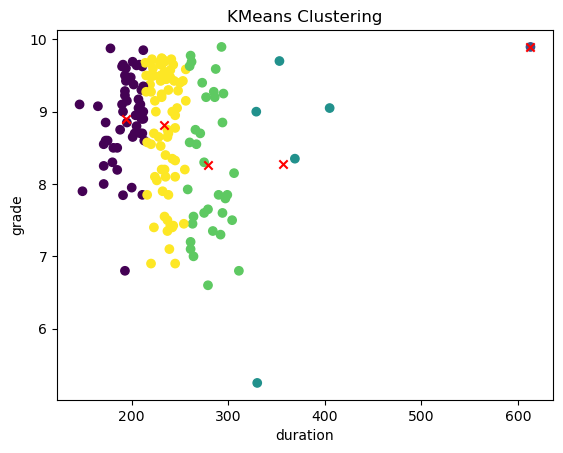

In [10]:
# Grafica los clusters
centers = model.clusterCenters()
plt.scatter(predictions.select(predictions.columns[0]).collect(),
            predictions.select(predictions.columns[1]).collect(),
            c=predictions.select('prediction').collect(),
            cmap='viridis')
plt.scatter([c[0] for c in centers], [c[1] for c in centers], c='red', marker='x')
plt.xlabel(predictions.columns[0])
plt.ylabel(predictions.columns[1])
plt.title('KMeans Clustering')
plt.show()

In [11]:
from pyspark.ml.evaluation import ClusteringEvaluator
print("k = " + str(k_value))

# Calcula WSSSE (cuanto menor, mejor)
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

# Calcula el coeficiente de Silhouette (1=buen cluster, -1=mal cluster)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


k = 5
Within Set Sum of Squared Errors = 34228.25580191216
Silhouette with squared euclidean distance = 0.6999635153863457


In [12]:
# Guarda los datos con las etiquetas de los clusters en un nuevo CSV
predictions.select('duration', 'grade', 'prediction').toPandas().to_csv('taylor_clustered.csv', index=False)